In [1]:
import pandas as pd
import numpy as np
import cv2
from random import randint
import matplotlib.pyplot as plt
import seaborn as sn
import keras
from sklearn import metrics
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense 
from tensorflow.keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [2]:
labels_df = pd.read_csv("train.csv", index_col=False)
labels_df.head()

,image_name,class
0,Patient00168_Plane3_1_of_3,Trans-thalamic
1,Patient00168_Plane3_2_of_3,Trans-thalamic
2,Patient00168_Plane3_3_of_3,Trans-cerebellum
3,Patient00188_Plane3_1_of_3,Trans-thalamic
4,Patient00188_Plane3_2_of_3,Trans-ventricular


In [3]:
path = './data/data/'
img_w, img_h = 220, 220    # width and height of image
Train_images = []
Train_labels = []
for img_name in labels_df['image_name'].values:
    image = cv2.imread(path+img_name+'.png')
    image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
    Train_images.append(image)
    
    label = labels_df[labels_df["image_name"]==img_name]['class'].values[0]
    Train_labels.append(label)
    
Train_images = np.array(Train_images)

In [4]:
labels_df['class'].unique()

array(['Trans-thalamic', 'Trans-cerebellum', 'Trans-ventricular', 'Other'],
      dtype=object)

In [5]:
CLASSES = ['Trans-thalamic', 'Trans-cerebellum', 'Trans-ventricular', 'Other']
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):    # foreach class
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

Train_labels = get_class_index(Train_labels)

In [6]:
print('Shape of train images: {}'.format(Train_images.shape))
print('Shape of train labels: {}'.format(Train_labels.shape))

Shape of train images: (2500, 330, 330, 3)
Shape of train labels: (2500,)


## Plot images and their labels for preview :

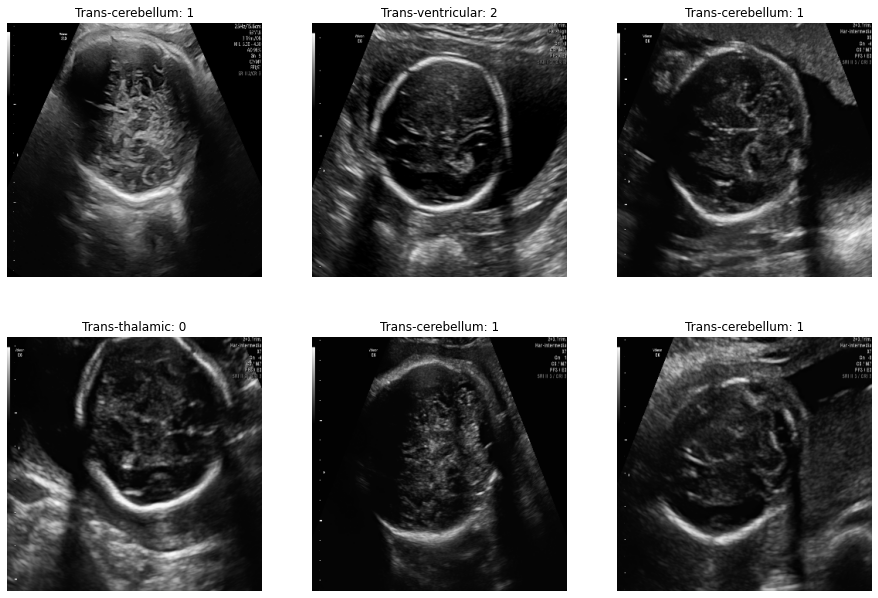

In [7]:
dim = 2 # 2x2 dimension flat plot
f,ax = plt.subplots(2,3) 
f.subplots_adjust(0,0,2,2)
for i in range(0,2):
    for j in range(0,3):
        rnd_number = randint(0,len(Train_images))
        cl = Train_labels[rnd_number]
        ax[i,j].imshow(Train_images[rnd_number])
        ax[i,j].set_title(CLASSES[cl]+': ' + str(cl))
        ax[i,j].axis('off')

In [8]:
num_classes = 4
top_model_weights_path = 'bottleneck_fc_model.h5'
#Default dimensions we found online
img_width, img_height = 224, 224 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 


from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_images, Train_labels, shuffle = True, test_size = 0.1, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (2250, 330, 330, 3), y_train: (2250,) 
Shape of X_val: (250, 330, 330, 3), y_val: (250,) 


In [9]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

model = Sequential() 
model.add(Flatten(input_shape=X_train.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='binary_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])

history = model.fit(X_train, y_train, 
   epochs=100,
   batch_size=batch_size, 
   validation_data=(X_val, y_val))

model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    X_val, y_val, batch_size=batch_size,     verbose=1)
print('[INFO] accuracy: {:.2f}%'.format(eval_accuracy * 100)) 
print('[INFO] Loss: {}'.format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
45/45 [==============================] - 19s 402ms/step - loss: 357.3401 - acc: 0.3440 - val_loss: 65.6679 - val_acc: 0.4440
Epoch 2/100
45/45 [==============================] - 18s 398ms/step - loss: 280.7908 - acc: 0.3791 - val_loss: 166.9337 - val_acc: 0.3760
Epoch 3/100
45/45 [==============================] - 18s 397ms/step - loss: 258.6350 - acc: 0.4058 - val_loss: 70.7849 - val_acc: 0.4480
Epoch 4/100
45/45 [==============================] - 18s 395ms/step - loss: 233.4904 - acc: 0.4004 - val_loss: 177.2097 - val_acc: 0.4080
Epoch 5/100
45/45 [==============================] - 18s 394ms/step - loss: 215.4436 - acc: 0.4231 - val_loss: 70.7517 - val_acc: 0.4880
Epoch 6/100
45/45 [==============================] - 18s 398ms/step - loss: 211.0734 - acc: 0.4440 - val_loss: 106.9890 - val_acc: 0.4320
Epoch 7/100
45/45 [==============================] - 18s 398ms/step - loss: 193.5443 - acc: 0.4587 - val_loss: 94.8375 - val_acc: 0.4720
Epoch 8/100
45/45 [===================

In [10]:
test_df = pd.read_csv('./test.csv')

In [11]:
path = './data/data/'
img_w, img_h = 220, 220    # width and height of image
Test_images = []
for img_name in test_df['image_name'].values:
    image = cv2.imread(path+img_name+'.png')
    image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
    Test_images.append(image)
    
Test_images = np.array(Test_images)

In [12]:
preds = np.round(model.predict(Test_images),0)
len(preds)

592

In [13]:
len(Test_images)

592

In [14]:
 ['Trans-thalamic', 'Trans-cerebellum', 'Trans-ventricular', 'Other']
preds_ = []
for pred in preds:
    if pred[0] == 1:
        preds_.append('Trans-thalamic')
    elif pred[1] == 1:
        preds_.append('Trans-cerebellum')
    elif pred[2] == 1:
        preds_.append('Trans-ventricular')
    elif pred[3] == 1:
        preds_.append('Other') 

In [15]:
image_name = list(test_df['image_name'].values)

In [16]:
d = {'image_name':image_name,'class':preds_}
pd.DataFrame(d).to_csv('sub3.csv',index=False)

In [17]:
pd.read_csv('sub3.csv')

,image_name,class
0,Patient01563_Plane3_1_of_3,Trans-cerebellum
1,Patient01563_Plane3_2_of_3,Trans-cerebellum
2,Patient01563_Plane3_3_of_3,Trans-thalamic
3,Patient01564_Plane3_1_of_2,Trans-thalamic
4,Patient01564_Plane3_2_of_2,Trans-cerebellum
...,...,...
587,Patient01790_Plane3_2_of_2,Trans-thalamic
588,Patient01791_Plane3_1_of_3,Trans-thalamic
589,Patient01791_Plane3_2_of_3,Trans-thalamic
590,Patient01791_Plane3_3_of_3,Trans-thalamic
